---
title: "Analyze generated dataset"
execute:
  echo: true
  enabled: false
  output: true
  warning: false
---

In [1]:
#| echo: false
#| output: false
basepath = "/home/u1/"

In [2]:
#| echo: false
#| output: false
import os
os.environ["MODIN_ENGINE"] = "dask"
import modin.pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [3]:
from detect_common import *

## Real-world scenario experiment with FluBot infected machine

Traffic stored in `v9_1.csv` (B1) and `v9_2.csv` (B2) (@fig-timeline).

Let's convert it to feather for faster processing, and get a bird view on the data.

In [4]:
#| output: false

df = pd.read_csv(basepath + "datasets/flubot20230323/data/v9_1.csv")
df.to_feather("cached/v9_1.ft")
df = pd.read_csv(basepath + "datasets/flubot20230323/data/v9_2.csv")
df.to_feather("cached/v9_2.ft")

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

2023-03-27 10:26:22,083 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-jv0lovd2', purging
2023-03-27 10:26:22,084 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-f15qalwg', purging
2023-03-27 10:26:22,084 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-yr1nuiez', purging
2023-03-27 10:26:22,084 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-kfx2t5_l', purging
2023-03-27 10:26:22,085 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-trg8hkgb', purging
2023-03-27 10:26:22,085 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wpnnxv3q', p

In [5]:
import dateutil.parser

df1 = pd.read_feather("cached/v9_1.ft")
df1["time TIME_FIRST"] = df1["time TIME_FIRST"].apply(dateutil.parser.parse)

In [6]:
len(df1)

12167

In [7]:
df2 = pd.read_feather("cached/v9_2.ft")
df2["time TIME_FIRST"] = df2["time TIME_FIRST"].apply(dateutil.parser.parse)

In [8]:
len(df2)

158678

In [9]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 158678 entries, 0 to 158677
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------------------------  ---------------  ----- 
 0   ipaddr DST_IP             158678 non-null  object
 1   ipaddr SRC_IP             158678 non-null  object
 2   uint64 BYTES              158678 non-null  int64
 3   uint64 BYTES_REV          158678 non-null  int64
 4   uint64 LINK_BIT_FIELD     158678 non-null  int64
 5   time TIME_FIRST           158678 non-null  object
 6   time TIME_LAST            158678 non-null  object
 7   macaddr DST_MAC           158678 non-null  object
 8   macaddr SRC_MAC           158678 non-null  object
 9   uint32 PACKETS            158678 non-null  int64
 10  uint32 PACKETS_REV        158678 non-null  int64
 11  uint16 DST_PORT           158678 non-null  int64
 12  uint16 SRC_PORT           158678 non-null  int64
 13  uint16 TLS_VERSION        158678 non-null  int64
 14  uint8 D

In [37]:
max_ts_b1 = df1["time TIME_FIRST"].max() - pd.Timedelta(minutes=5)

In [39]:
# skip last 5 mins of traffic where we have fluctiations because of stopped traffic2.py script
local_df1 = df1[df1["ipaddr SRC_IP"].str.startswith("192.168")]
local_df1 = local_df1[local_df1["time TIME_FIRST"] < max_ts_b1]

local_df2 = df2[df2["ipaddr SRC_IP"].str.startswith("192.168")]
len(local_df1), len(local_df2)

(8870, 149890)

In [ ]:
local_ips2 = local_df2["ipaddr SRC_IP"].unique().tolist()
local_ips2

In [12]:
local_ips1 = local_df1["ipaddr SRC_IP"].unique().tolist()
local_ips = list(set(local_ips1 + local_ips2))
local_ips

['192.168.2.149', '192.168.2.42', '192.168.2.217', '192.168.1.1']

In [13]:
min_ts = local_df1["time TIME_FIRST"].min()
min_ts_b2 = local_df2["time TIME_FIRST"].min()
min_ts, min_ts_b2

(Timestamp('2023-03-27 06:34:34.435834'),
 Timestamp('2023-03-27 08:11:28.539603'))

## B1 period vs B2 period

In [19]:
infection_ts = min_ts + pd.Timedelta(minutes=160)
infection_ts

Timestamp('2023-03-27 09:14:34.435834')

In [20]:
local_df2_a1 = local_df2[local_df2["time TIME_FIRST"] < infection_ts]
local_df2_a2 = local_df2[local_df2["time TIME_FIRST"] >= infection_ts]

2023-03-27 10:30:02,841 - distributed.worker - ERROR - Exception during execution of task lambda-710be5a1d9124b3b0a92bb6787384a45.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-43a947a8-b4b8-4d2b-80cf-7839cd1b963a'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

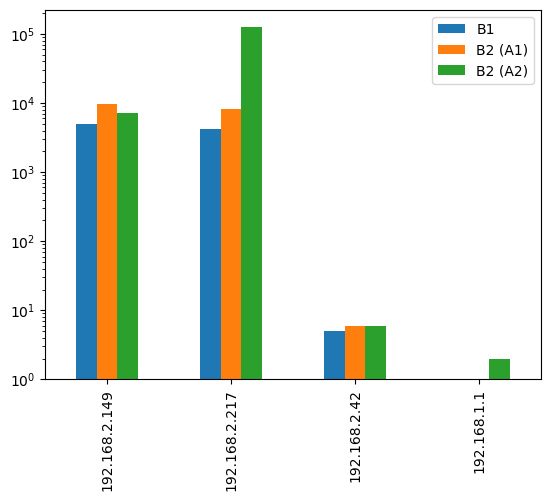

In [21]:
from matplotlib import pyplot as plt

d = {
    'B1': local_df1["ipaddr SRC_IP"].value_counts().to_dict(),
    'B2 (A1)': local_df2_a1["ipaddr SRC_IP"].value_counts().to_dict(),
    'B2 (A2)': local_df2_a2["ipaddr SRC_IP"].value_counts().to_dict(),
}

pd.DataFrame(d).plot(kind='bar', log=True)
plt.show()

## Plaintext DNS vs whole HTTPS traffic

2023-03-27 10:36:40,089 - distributed.worker - ERROR - Exception during execution of task lambda-84a742c2cfa2890fed318e9544b545fc.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-8e7db422-6ec7-4542-9b6c-168ee3ad03f1'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

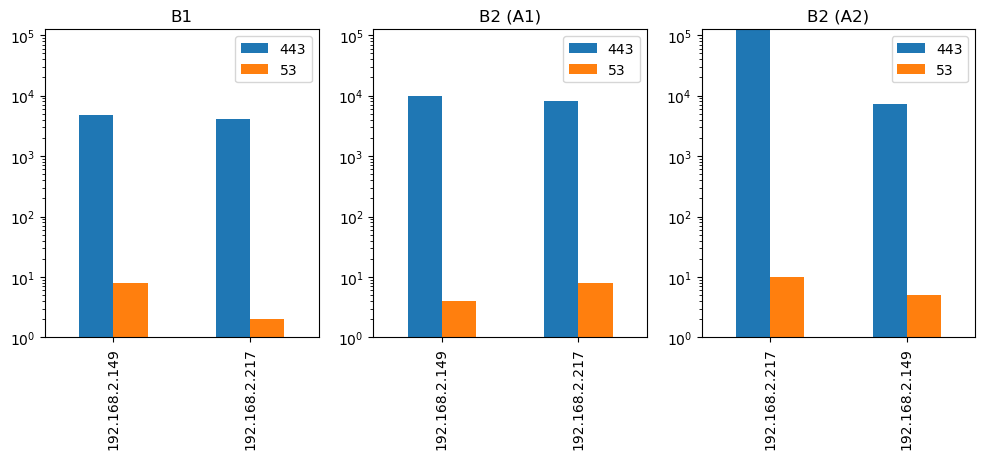

In [22]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

max_val = 0
for ax, df, title in zip(axs, [local_df1, local_df2_a1, local_df2_a2], ["B1", "B2 (A1)", "B2 (A2)"]):
    d = {
        '443': df[df["uint16 DST_PORT"] == 443]["ipaddr SRC_IP"].value_counts().to_dict(),
        '53': df[df["uint16 DST_PORT"] == 53]["ipaddr SRC_IP"].value_counts().to_dict(),
    }
    max_val = max(max_val, *[v2 for v in d.values() for v2 in v.values()])
    pd.DataFrame(d).plot(kind='bar', log=True, ax=ax, title=title)

for ax in axs:
    ax.set_ylim(ymin=0, ymax=max_val)
    
plt.show()

## Timeline of the traffic

In [23]:
f = '2min'

def plot_packets_by_port(local_df, host, dst_port):
    a1_t = local_df[local_df["ipaddr SRC_IP"] == host].set_index(["time TIME_FIRST"])

    a1_t53 = a1_t[a1_t["uint16 DST_PORT"] == dst_port][["uint32 PACKETS", "uint32 PACKETS_REV"]]
    a1_t53["PACKETS"] = a1_t53["uint32 PACKETS"] + a1_t53["uint32 PACKETS_REV"]
    df_resample = a1_t53.groupby(pd.Grouper(freq=f, origin=min_ts)).sum()
    return df_resample


In [40]:
local_df = pd.concat([local_df1, local_df2]).reset_index(drop=True)

2023-03-27 14:20:09,809 - distributed.worker - ERROR - Exception during execution of task lambda-d610b1679b5adc67d81e8b1017dcf76c.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-d7e79c5a-0eea-49e3-9236-efa071e9abe9'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

In [41]:
df_plots = {h: plot_packets_by_port(local_df, h, 53) for h in local_ips}

2023-03-27 14:20:57,594 - distributed.worker - ERROR - Exception during execution of task lambda-fe939da8c956a0b4e1d26ff7310cd3f0.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-2a69981d-bd67-47ee-a0d0-2e8a6ba698b2'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

[]

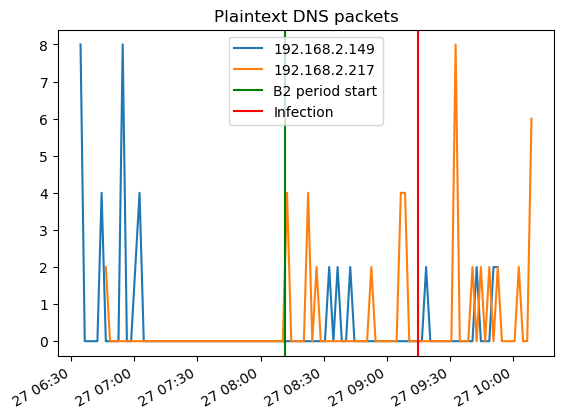

In [42]:
pd.DataFrame({
    h: df["PACKETS"].to_dict()
    for h, df in df_plots.items()
    if len(df) > 0
}).plot()

plt.axvline(x=min_ts_b2, label="B2 period start", color="green")
plt.axvline(x=infection_ts, label="Infection", color="red")

plt.title("Plaintext DNS packets")
plt.legend()
plt.plot()

In [43]:
df_plots = {h: plot_packets_by_port(local_df, h, 443) for h in local_ips}


2023-03-27 14:22:39,536 - distributed.worker - ERROR - Exception during execution of task lambda-6a601e15f88d3bb995cb9c4b3e6e3669.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-e2e1d766-dfd5-46ba-adf7-25a3bb22249a'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

[]

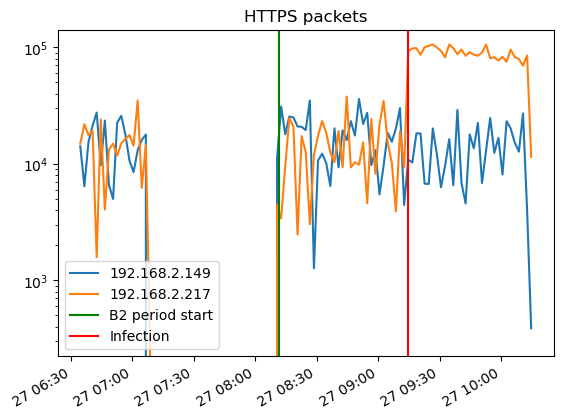

In [44]:
pd.DataFrame({
    h: df["PACKETS"].to_dict()
    for h, df in df_plots.items()
    if len(df) > 0
}).plot(logy=True)

plt.axvline(x=min_ts_b2, label="B2 period start", color="green")
plt.axvline(x=infection_ts, label="Infection", color="red")

plt.title("HTTPS packets")
plt.legend()
plt.plot()